### Soccermatics
#### Assignment 2
##### Instructions
* It is summer of 2018. The head scout of your club (the one which group you are in) is looking to sign a player to improve your defence. It doesn't need to be a defender. But it does need to be a player who will strength some aspect of your defensive play.
* She is interested in hearing about a variety of methods for scouting players, so she asks you to create a player radar. You should primarily use the Wyscout data, but can also use Transfermarkt to find the prices of players in summer 2018.
* You should do the following steps:
   1. Implement a number of defensive metrics based on statistical scouting (lesson 3) and valuing actions (lesson 4).
      * Four to six metrics is about right.
      * Create player radars for your own team's players in the position you aim to replace (one of goalkeeper, defender, midfielder, forward).
      * Write a simple non-technical text (at most one page) explaining your radars to the scout and what assumptions it makes.
      * Points will be awarded for the novelty of the metric, the clarity of the explanation and for the technical difficulty of the contribution. (12 points).
   2. Use one of the metrics on your radar to find a single player in another league (not the Premier league), who you would recommend signing.
      * Produce a top-10 list of players in this league for one of the metrics.
      * On this basis, choose a player you would recommend and create a player radar for him. (3 points)
   3. By midnight Friday 30th September send your report (steps 1 and 2) to the other members of your group.
      * On Monday the 3rd of October, you will each present a radar for your player chosen in stage 2 within your group.
      * Your presentation should be no more than 2 minutes.
      * After the presentations, you will have a group discussion comparing your choices.
      * You should write contrasting your own and the other reports and make a final recommendation on this basis (participation in meeting 2 points; final report 3 points)
   4. The final report (deadline Wednesday 5th October) should be 4 pages: roughly 2 pages for part 1, 1 page for part 2, and 1 page for part 3.
   
   
Submit a separate runnable piece of code (preferably in Python) which when put in the directory of the Wyscout data creates the radars. This code must be single file and only uses standard libraries (mplsoccer is fine) and should be runnable when put in the folder with Wyscout data.

Our group chose to scout for Brighton & Hove Albion. 

I decided to search for a midfielder who can help improve defensive outcomes and also trigger attacks by evaluating performance across the following metrics:
(all posession adjusted per 90):
* Interceptions
* Defensive duel won via anticipation
* Passes made from just outside the defensive box (an area equal to the box)
* Key passes


TO DO
1. Passing success %
2. xT contribution (including negative)
3. Adjust defensive actions for opposition possession (is this not just the inverse?)
4. Age / market value from Transfermarkt
5. Brighton's most valuable player / biggest transfer fee paid
6. Parametise position ("midfield") and club ("Brighton & Hove Albion")

In [1]:
import pandas as pd
import numpy as np

import datetime as dt

from tqdm import tqdm

from dataclasses import dataclass

import matplotlib as mpl
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
import pathlib
import warnings

import recordlinkage
from recordlinkage.preprocessing import clean

from scipy import stats
from mplsoccer import Pitch, PyPizza, FontManager

In [2]:
CURRENT_DATE = dt.date(2018, 6, 1) # "Summer 2018"

MINIMUM_90s = 5
TARGET_ROLE = 'Midfielder' # Goalkeeper, Defender, Midfielder, Forward

WYSCOUT_MIN_COORD = 0
WYSCOUT_MAX_COORD = 100

WYSCOUT_EDGE_OF_BOX_X = 16
WYSCOUT_EDGE_OF_BOX_Y_MIN = 19
WYSCOUT_EDGE_OF_BOX_Y_MAX = 81

COLOUR_DEFENCE = '#fcc2d7'
COLOUR_ATTACK = '#a5d8ff'

COLOUR_BACKGROUND = '#f7f3ed'
COLOUR_ALMOST_BLACK = '#323232'

In [3]:
mpl.rcParams['figure.dpi']= 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [4]:
# incomplete but good enough?
# this data uses v2 API
# https://docs.google.com/document/d/11mNbM7kX2xKStQ1UCoBfUgYNxJ2b1Kgqrg_x8wC6JQo/edit
# https://apidocs.wyscout.com/
wyscout_tags = [
    (101, 'goal'),
    (102, 'own_goal'),
    (301, 'assist'),
    (302, 'key_pass'),
    (1901, 'counter_attack'),
    (401, 'left_foot'),
    (402, 'right_foot'),
    (403, 'head/body'),
    (1101, 'direct'),
    (1102, 'indirect'),
    (2001, 'dangerous_ball_lost'),
    (2101, 'blocked'),
    (801, 'high'),
    (802, 'low'),
    (1401, 'interception'),
    (1501, 'clearance'),
    (201, 'opportunity'),
    (1301, 'feint'),
    (1302, 'missed_ball'),
    (501, 'free_space_right'),
    (502, 'free_space_left'),
    (503, 'take_on_left'),
    (504, 'take_on_right'),
    (1601, 'sliding_tackle'),
    (601, 'anticipated'),
    (602, 'anticipation'),
    (1701, 'red_card'),
    (1702, 'yellow_card'),
    (1703, 'second_yellow_card'),
    (1201, 'position_goal_low_center'),
    (1202, 'position_goal_low_right'),
    (1203, 'position_goal_mid_center'),
    (1204, 'position_goal_mid_left'),
    (1205, 'position_goal_low_left'),
    (1206, 'position_goal_mid_right'),
    (1207, 'position_goal_high_center'),
    (1208, 'position_goal_high_left'),
    (1209, 'position_goal_high_right'),
    (1210, 'position_out_low_right'),
    (1211, 'position_out_mid_left'),
    (1212, 'position_out_low_left'),
    (1213, 'position_out_mid_right'),
    (1214, 'position_out_high_center'),
    (1215, 'position_out_high_left'),
    (1216, 'position_out_high_right'),
    (1217, 'position_post_low_right'),
    (1218, 'position_post_mid_left'),
    (1219, 'position_post_low_left'),
    (1220, 'position_post_mid_right'),
    (1221, 'position_post_high_center'),
    (1222, 'position_post_high_left'),
    (1223, 'position_post_high_right'),
    (901, 'through'),
    (1001, 'fairplay'),
    (701, 'lost'),
    (702, 'neutral'),
    (703, 'won'),
    (1801, 'accurate'),
    (1802, 'not_accurate')
]

In [5]:
wyscout_tags_dict = dict(wyscout_tags)

In [6]:
def get_wyscout_data(file_name, sub_directory=None):

    if sub_directory:
        path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', sub_directory, file_name)
    else:
        path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', file_name)

    #open data
    with open(path, encoding='utf-8') as f:
        df = pd.read_json(f, encoding='utf-8')
    
    return df

In [7]:
df_competitions = get_wyscout_data('competitions.json')
df_teams = get_wyscout_data('teams.json')
df_players = get_wyscout_data('players.json')
df_players['role_name'] = df_players['role'].apply(lambda x: x.get('name'))
df_players['birthDate'] = pd.to_datetime(df_players['birthDate']).dt.date

In [8]:
# clean utf-8 names thingo
for column in ['firstName', 'lastName', 'shortName']:
    df_players[column] = df_players[column].str.decode("unicode-escape")


# create no accented surname column
df_players['last_name_no_accent'] = clean(df_players['lastName'], strip_accents='unicode')

recordlinkage\preprocessing\cleaning.py:114: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r'(\[.*?\]|\(.*?\)|\{.*?\})', '')
recordlinkage\preprocessing\cleaning.py:118: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(replace_by_none, '')
recordlinkage\preprocessing\cleaning.py:121: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(replace_by_whitespace, ' ')
recordlinkage\preprocessing\cleaning.py:124: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r'\s\s+', ' ')


In [9]:
df_teams['league_or_nation'] = df_teams['area'].apply(lambda x: x.get('name'))

clubs_not_from_nation = {
    'Monaco' : 'France',
    'Wales' : 'England'
}

df_teams['league_or_nation'] = np.where(df_teams['league_or_nation'].isin(clubs_not_from_nation.keys()), df_teams['league_or_nation'].map(clubs_not_from_nation), df_teams['league_or_nation'])

In [10]:
df_teams_small = df_teams[df_teams['type']=='club'][['wyId', 'name', 'league_or_nation']]
df_teams_small.columns = ['team_id', 'team_name', 'league']
df_teams_small['team_name'] = df_teams_small['team_name'].str.decode("unicode-escape")
df_teams_small

,team_id,team_name,league
0,1613,Newcastle United,England
1,692,Celta de Vigo,Spain
2,691,Espanyol,Spain
3,696,Deportivo Alavés,Spain
4,695,Levante,Spain
...,...,...,...
93,684,Real Betis,Spain
94,687,Real Sociedad,Spain
95,680,Sevilla,Spain
96,683,Málaga,Spain


In [11]:
df_players['age'] = (CURRENT_DATE - df_players['birthDate']).astype('timedelta64[D]') / 365.25
df_players = df_players.merge(df_teams_small, how='left', left_on='currentTeamId', right_on='team_id')

In [12]:
league_countries = ['England', 'Spain', 'Italy', 'Germany', 'France'] # ignore internationals i.e. World Cup and EUROs

In [13]:
matches = {}

for country in league_countries:
    file_name = 'matches_' + country + '.json'
    matches[country] = get_wyscout_data(file_name, sub_directory='matches')

df_matches = pd.concat(matches).reset_index()

In [14]:
events = {}

for country in tqdm(league_countries):
    file_name = 'events_' + country + '.json'
    events[country] = get_wyscout_data(file_name, sub_directory='events')

df_events = pd.concat(events).reset_index()

100%|██████████| 5/5 [01:52<00:00, 22.46s/it]


In [15]:
minutes_per_game = {}

for country in league_countries:
    file_name = 'minutes_played_per_game_' + country + '.json'
    minutes_per_game[country] = get_wyscout_data(file_name, sub_directory='minutes_played')

df_minutes_per_game = pd.concat(minutes_per_game).reset_index()

In [16]:
group_by = ['playerId', 'shortName'] # group_by = ['level_0', 'playerId', 'shortName']

df_minutes_season = df_minutes_per_game[group_by + ['minutesPlayed']].groupby(group_by).sum()
df_minutes_season

,,minutesPlayed
playerId,shortName,
33,J. Cillessen,93
36,T. Alderweireld,1238
38,D. Blind,382
45,G. van der Wiel,313
48,J. Vertonghen,3343
...,...,...
545811,Hugo Duro,24
551398,David Alba,63
564512,S. Sanogo,44


In [17]:
team_id_brighton = df_teams[df_teams['name']=='Brighton & Hove Albion']['wyId'].to_numpy()[0]
df_brighton_players = df_players[df_players['currentTeamId']==team_id_brighton]

In [18]:
df_events[['position_start', 'position_end']] = pd.DataFrame(df_events['positions'].to_list())

for coord in ['x', 'y']:
    df_events[coord + '_start'] = df_events['position_start'].apply(lambda x: x.get(coord))
    df_events[coord + '_end'] = df_events['position_end'].apply(lambda x: x.get(coord) if x else None)

df_events

,level_0,level_1,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,position_start,position_end,x_start,x_end,y_start,y_end
0,England,0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,"{'y': 49, 'x': 49}","{'y': 78, 'x': 31}",49,31.0,49,78.0
1,England,1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,"{'y': 78, 'x': 31}","{'y': 75, 'x': 51}",31,51.0,78,75.0
2,England,2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,"{'y': 75, 'x': 51}","{'y': 71, 'x': 35}",51,35.0,75,71.0
3,England,3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,"{'y': 71, 'x': 35}","{'y': 95, 'x': 41}",35,41.0,71,95.0
4,England,4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,"{'y': 95, 'x': 41}","{'y': 88, 'x': 72}",41,72.0,95,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071390,France,632802,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",405977,"[{'y': 65, 'x': 87}, {'y': 100, 'x': 100}]",2501065,Shot,19830,2H,2821.203869,100,253316980,"{'y': 65, 'x': 87}","{'y': 100, 'x': 100}",87,100.0,65,100.0
3071391,France,632803,9,Save attempt,"[{'id': 101}, {'id': 1208}, {'id': 1802}]",25521,"[{'y': 0, 'x': 0}, {'y': 35, 'x': 13}]",2501065,Save attempt,3795,2H,2824.817116,91,253316978,"{'y': 0, 'x': 0}","{'y': 35, 'x': 13}",0,13.0,0,35.0
3071392,France,632804,8,Simple pass,[{'id': 1801}],295761,"[{'y': 52, 'x': 50}, {'y': 47, 'x': 44}]",2501065,Pass,3795,2H,2888.383858,85,253316981,"{'y': 52, 'x': 50}","{'y': 47, 'x': 44}",50,44.0,52,47.0
3071393,France,632805,8,Simple pass,[{'id': 1801}],249926,"[{'y': 47, 'x': 44}, {'y': 8, 'x': 41}]",2501065,Pass,3795,2H,2889.654402,85,253316982,"{'y': 47, 'x': 44}","{'y': 8, 'x': 41}",44,41.0,47,8.0


In [19]:
group_by = ['eventId', 'subEventId', 'eventName', 'subEventName']

df_events_grouped = df_events[group_by + ['id']].groupby(group_by).count().sort_values('eventId', ascending=False)
df_events_grouped.columns = ['number_of_events']
df_events_grouped

number_of_events
eventId subEventId eventName               subEventName                             
10      100        Shot                    Shot                                40461
9       91         Save attempt            Save attempt                         6375
        90         Save attempt            Reflexes                            10192
8       83         Pass                    High pass                          123214
        80         Pass                    Cross                               58634
        81         Pass                    Hand pass                           13135
        82         Pass                    Head pass                           91194
        84         Pass                    Launch                              43303
        85         Pass                    Simple pass                       1207448
        86         Pass                    Smart pass                          28428
7       72         Others on the ball      Touch                              165296
        71         Others on the ball      Clearance                           53165
        70         Others on the ball      Acceleration                        24376
6                  Offside                                                      7821
5       51         Interruption            Whistle                               917
        50         Interruption            Ball out of the field              129179
4       40         Goalkeeper leaving line Goalkeeper leaving line              5779
3       36         Free Kick               Throw in                            80305
        34         Free Kick               Goal kick                           29725
        33         Free Kick               Free kick shot                       2038
        32         Free Kick               Free kick cross                      8134
        31         Free Kick               Free Kick                           43544
        30         Free Kick               Corner                              18181
        35         Free Kick               Penalty                               541
2       25         Foul                    Simulation                            108
        27         Foul                    Violent Foul                           74
        26         Foul                    Time lost foul                        205
        24         Foul                    Protest                               561
        23         Foul                    Out of game foul                      473
        22         Foul                    Late card foul                        300
        21         Foul                    Hand foul                            1941
        20         Foul                    Foul                                44293
1       12         Duel                    Ground defending duel              264552
        11         Duel                    Ground attacking duel              265456
        13         Duel                    Ground loose ball duel             143861
        10         Duel                    Air duel                           158186

In [20]:
def filter_by_event_or_sub_event(df=df_events, eventId=None, subEventId=[], x_min=WYSCOUT_MIN_COORD, x_max=WYSCOUT_MAX_COORD, y_min=WYSCOUT_MIN_COORD, y_max=WYSCOUT_MAX_COORD):

    df_filtered = df.copy(deep=True)
    
    if eventId:
        df_filtered = df_filtered[df_filtered['eventId']==eventId]

    if subEventId:
        df_filtered = df_filtered[df_filtered['subEventId'].isin(subEventId)]

    location_filters = (df_filtered['x_start'] >= x_min) & (df_filtered['x_start'] <= x_max) & (df_filtered['y_start'] >= y_min) & (df_filtered['y_start'] <= y_max)
    df_filtered = df_filtered[location_filters]

    return df_filtered

In [21]:
def get_tags_for_event(eventId=None, subEventId=None):

    df_filtered = filter_by_event_or_sub_event(eventId=eventId, subEventId=subEventId)
        
    df_exploded = df_filtered.explode('tags')
    df_exploded['tag_id'] = df_exploded['tags'].apply(lambda x: x.get('id'))

    df_grouped = df_exploded[['tag_id', 'eventName', 'subEventName', 'eventId']].groupby(['eventName', 'subEventName', 'tag_id']).count()
    df_grouped = df_grouped.sort_values('eventId', ascending=False)
    df_grouped.columns = ['number_of_events']

    return df_grouped

In [22]:
get_tags_for_event(eventId=1, subEventId=[12])

number_of_events
eventName subEventName          tag_id                  
Duel      Ground defending duel 1801              133399
                                1802              131153
                                701               130720
                                702                75284
                                703                58111
                                502                30149
                                501                29330
                                504                27143
                                503                22843
                                601                16358
                                1601               12299
                                1901                2886
                                602                  182
                                1702                   1
                                1703                   1

In [23]:
def get_metrics(df=df_events, eventId=None, subEventId=None, x_min=WYSCOUT_MIN_COORD, x_max=WYSCOUT_MAX_COORD, y_min=WYSCOUT_MIN_COORD, y_max=WYSCOUT_MAX_COORD, tags=[]):
    '''
    Takes a Wyscout Event ID and/or Sub Event ID, plus a list of Wyscout event tags
    Returns a dataframe of events where all tags in the list were found
    '''

    df_events_meeting_criteria = filter_by_event_or_sub_event(eventId=eventId, subEventId=subEventId, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

    for tag in tags:
        tag_name = wyscout_tags_dict[tag]
        df_events_meeting_criteria[tag_name] = df_events_meeting_criteria['tags'].apply(lambda x: {'id':tag} in x)
        df_events_meeting_criteria = df_events_meeting_criteria[df_events_meeting_criteria[tag_name]==True]

    return df_events_meeting_criteria

In [24]:
get_metrics(tags=[2101]).groupby(['subEventName']).count()

,level_0,level_1,eventId,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,position_start,position_end,x_start,x_end,y_start,y_end,blocked
subEventName,,,,,,,,,,,,,,,,,,,,
Corner,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
Cross,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677
Free kick cross,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45
Free kick shot,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680
Shot,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548


In [25]:
def summarise_events_by_player(df_of_specific_events, plain_english_label=False):
    
    df_grouped = df_of_specific_events[['playerId', 'id']].groupby('playerId').count()
    df_grouped.columns = [plain_english_label]

    return df_grouped

In [26]:
@dataclass
class PlayerMetric:
    '''Class for storing a complete definition of a player metric.'''
    metric_name: str
    eventId: int = None
    subEventId: list = None
    tags: list = None
    ranking_weight: float = 1.0 # for weighting importance in multiple feature ranking
    x_start_min: float = WYSCOUT_MIN_COORD
    x_start_max: float = WYSCOUT_MAX_COORD
    y_start_min: float = WYSCOUT_MIN_COORD
    y_start_max: float = WYSCOUT_MAX_COORD
    bigger_is_better: bool = True # false if something like giving the ball away
    possession_adjustment_perspective: str = 'team' # "team" for on the ball events, "opposition" for defensive metrics e.g. tackles
    pizza_slice_colour: str = 'black'

    def clean_metric_name(self) -> str:
        clean_metric_name = self.metric_name.capitalize().replace('_', ' ')
        return clean_metric_name

    def per_90(self) -> str:
        metric_name_per_90 = self.metric_name + '_p90'
        return metric_name_per_90

    def per_90_possession_adjusted(self) -> str:
        metric_name_per_90_possession_adjusted = self.metric_name + '_p90_padj'
        return metric_name_per_90_possession_adjusted

In [27]:
metrics_definitions = [
    PlayerMetric(metric_name='ground_duels_won_by_anticipation', eventId=1, subEventId=[12], ranking_weight=3,
                 tags=[601, 1801], bigger_is_better=True, possession_adjustment_perspective='opposition', pizza_slice_colour=COLOUR_DEFENCE),

    PlayerMetric(metric_name='interceptions', eventId=None, subEventId=None, tags=[1401], ranking_weight=3,
        bigger_is_better=True, possession_adjustment_perspective='opposition', pizza_slice_colour=COLOUR_DEFENCE),

    PlayerMetric(metric_name='key_passes', eventId=8, tags=[302, 1801], ranking_weight=1,
        bigger_is_better=True, possession_adjustment_perspective='team', pizza_slice_colour=COLOUR_ATTACK),

#    PlayerMetric(metric_name='passes_as_part_of_counterattack', eventId=8, tags=[1901, 1801],
#        bigger_is_better=True, possession_adjustment_perspective='team'),

    PlayerMetric(metric_name='passes_from_outside_defensive_box', eventId=8, subEventId=[83, 86], tags=[1801], ranking_weight=2,
        x_start_min=WYSCOUT_EDGE_OF_BOX_X, x_start_max=WYSCOUT_EDGE_OF_BOX_X * 2, y_start_min=WYSCOUT_EDGE_OF_BOX_Y_MIN, y_start_max=WYSCOUT_EDGE_OF_BOX_Y_MAX, bigger_is_better=True, possession_adjustment_perspective='team', pizza_slice_colour=COLOUR_ATTACK),
    # PlayerMetric('dangerous_balls_given_away', None, None, [2001], False),

 #   PlayerMetric(metric_name='fouls_committed', eventId=2, tags=[], ranking_weight=1,
 #       bigger_is_better=False, possession_adjustment_perspective='opposition', pizza_slice_colour=COLOUR_DEFENCE),
]


In [28]:
df_player_aggregates = pd.DataFrame()

for definition in metrics_definitions:
    df_each_event = get_metrics(df=df_events, eventId=definition.eventId,
                                subEventId=definition.subEventId, tags=definition.tags)
    df_player_aggregates = pd.concat([df_player_aggregates, summarise_events_by_player(
        df_each_event, definition.metric_name)], axis=1)

In [29]:
df_player_aggregates

,ground_duels_won_by_anticipation,interceptions,key_passes,passes_from_outside_defensive_box
playerId,,,,
0,1106.0,240.0,NaN,2.0
36,1.0,54.0,2.0,81.0
38,2.0,21.0,1.0,12.0
45,1.0,17.0,1.0,7.0
48,33.0,211.0,3.0,91.0
...,...,...,...,...
364641,NaN,NaN,NaN,2.0
437011,NaN,NaN,NaN,1.0
450826,NaN,NaN,NaN,2.0


In [30]:
df_all_players = df_players[['wyId', 'shortName', 'firstName', 'lastName', 'last_name_no_accent', 'birthDate', 'team_name', 'league', 'role_name']]
df_all_players

,wyId,shortName,firstName,lastName,last_name_no_accent,birthDate,team_name,league,role_name
0,32777,H. Tekin,Harun,Tekin,tekin,1989-06-17,NaN,NaN,Goalkeeper
1,393228,M. Sarr,Malang,Sarr,sarr,1999-01-23,Nice,France,Defender
2,393230,O. Mandanda,Over,Mandanda,mandanda,1998-10-26,Bordeaux,France,Goalkeeper
3,32793,A. N'Diaye,Alfred John Momar,N'Diaye,ndiaye,1990-03-06,Málaga,Spain,Midfielder
4,393247,I. Konaté,Ibrahima,Konaté,konate,1999-05-25,RB Leipzig,Germany,Defender
...,...,...,...,...,...,...,...,...,...
3598,120839,A. Maâloul,Ali,Maâloul,maaloul,1990-01-01,NaN,NaN,Defender
3599,114736,C. Cáceda,Carlos Alberto,Cáceda Oyaguez,caceda oyaguez,1991-09-27,NaN,NaN,Goalkeeper
3600,114908,M. Araujo,Miguel Gianpierre,Araujo Blanco,araujo blanco,1994-10-24,NaN,NaN,Defender
3601,285583,A. Tagnaouti,Ahmed Reda,Tagnaouti,tagnaouti,1996-04-05,NaN,NaN,Goalkeeper


In [31]:
df_all_players_with_minutes = df_all_players.merge(df_minutes_season, how='left', left_on='wyId', right_on='playerId')
df_all_players_with_minutes['minutesPlayed'] = df_all_players_with_minutes['minutesPlayed'].fillna(0)
df_all_players_with_minutes['90s'] = df_all_players_with_minutes['minutesPlayed'] / 90
df_all_players_with_minutes = df_all_players_with_minutes[df_all_players_with_minutes['90s']>=MINIMUM_90s]
df_all_players_with_minutes.sort_values('minutesPlayed', ascending=False)

,wyId,shortName,firstName,lastName,last_name_no_accent,birthDate,team_name,league,role_name,minutesPlayed,90s
2915,8726,A. Begović,Asmir,Begović,begovic,1987-06-20,AFC Bournemouth,England,Goalkeeper,3612.0,40.133333
1540,20635,F. Acerbi,Francesco,Acerbi,acerbi,1988-02-10,Sassuolo,Italy,Defender,3591.0,39.900000
743,8653,H. Maguire,Harry,Maguire,maguire,1993-03-05,Leicester City,England,Defender,3586.0,39.844444
1794,350999,G. Donnarumma,Gianluigi,Donnarumma,donnarumma,1999-02-25,Milan,Italy,Goalkeeper,3583.0,39.811111
801,10131,J. Pickford,Jordan,Pickford,pickford,1994-03-07,Everton,England,Goalkeeper,3575.0,39.722222
...,...,...,...,...,...,...,...,...,...,...,...
90,99633,I. Lewczuk,Igor,Lewczuk,lewczuk,1985-05-30,Bordeaux,France,Defender,457.0,5.077778
413,364870,Adrián Diéguez,Adrián,Diéguez Grande,dieguez grande,1996-02-04,Deportivo Alavés,Spain,Defender,452.0,5.022222
562,366542,J. Reine-Adelaide,Jeff,Reine-Adelaide,reine adelaide,1998-01-17,Angers,France,Midfielder,451.0,5.011111
2697,658,S. Armenteros,Kristiano Samuel,Armenteros Nunez Mendoza Jansson,armenteros nunez mendoza jansson,1990-05-27,NaN,NaN,Forward,451.0,5.011111


In [32]:
df_all_players_with_minutes_and_metrics = df_all_players_with_minutes.merge(df_player_aggregates, how='left', left_on='wyId', right_index=True)

for definition in metrics_definitions:
    if definition.bigger_is_better:
        df_all_players_with_minutes_and_metrics[definition.metric_name] = df_all_players_with_minutes_and_metrics[definition.metric_name].fillna(0)

df_all_players_with_minutes_and_metrics

,wyId,shortName,firstName,lastName,last_name_no_accent,birthDate,team_name,league,role_name,minutesPlayed,90s,ground_duels_won_by_anticipation,interceptions,key_passes,passes_from_outside_defensive_box
1,393228,M. Sarr,Malang,Sarr,sarr,1999-01-23,Nice,France,Defender,1379.0,15.322222,6.0,71.0,1.0,45.0
4,393247,I. Konaté,Ibrahima,Konaté,konate,1999-05-25,RB Leipzig,Germany,Defender,1267.0,14.077778,9.0,72.0,1.0,39.0
6,36,T. Alderweireld,Toby,Alderweireld,alderweireld,1989-03-02,Tottenham Hotspur,England,Defender,1238.0,13.755556,1.0,54.0,2.0,81.0
7,48,J. Vertonghen,Jan,Vertonghen,vertonghen,1987-04-24,Tottenham Hotspur,England,Defender,3343.0,37.144444,33.0,211.0,3.0,91.0
8,229427,A. Djiku,Alexander,Djiku,djiku,1994-08-09,Caen,France,Defender,2613.0,29.033333,34.0,170.0,0.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402,292654,M. Diakhaby,Mouctar,Diakhaby,diakhaby,1996-12-19,Valencia,Spain,Defender,765.0,8.500000,5.0,55.0,0.0,8.0
3408,325781,J. Lea Siliki,James Edward,Lea Siliki,lea siliki,1996-06-12,Rennes,France,Midfielder,1820.0,20.222222,4.0,53.0,5.0,35.0
3409,326946,R. Coly,Racine,Coly,coly,1995-12-08,Nice,France,Defender,639.0,7.100000,3.0,42.0,1.0,2.0
3423,393214,V. Rosier,Valentin,Rosier,rosier,1996-08-19,Dijon,France,Defender,2881.0,32.011111,11.0,193.0,6.0,51.0


In [33]:
for metric in metrics_definitions:
    df_all_players_with_minutes_and_metrics[metric.per_90()] = df_all_players_with_minutes_and_metrics[metric.metric_name] / df_all_players_with_minutes_and_metrics['90s']

In [34]:
df_all_players_with_minutes_and_metrics

,wyId,shortName,firstName,lastName,last_name_no_accent,birthDate,team_name,league,role_name,minutesPlayed,90s,ground_duels_won_by_anticipation,interceptions,key_passes,passes_from_outside_defensive_box,ground_duels_won_by_anticipation_p90,interceptions_p90,key_passes_p90,passes_from_outside_defensive_box_p90
1,393228,M. Sarr,Malang,Sarr,sarr,1999-01-23,Nice,France,Defender,1379.0,15.322222,6.0,71.0,1.0,45.0,0.391588,4.633793,0.065265,2.936911
4,393247,I. Konaté,Ibrahima,Konaté,konate,1999-05-25,RB Leipzig,Germany,Defender,1267.0,14.077778,9.0,72.0,1.0,39.0,0.639305,5.114444,0.071034,2.770324
6,36,T. Alderweireld,Toby,Alderweireld,alderweireld,1989-03-02,Tottenham Hotspur,England,Defender,1238.0,13.755556,1.0,54.0,2.0,81.0,0.072698,3.925687,0.145396,5.888530
7,48,J. Vertonghen,Jan,Vertonghen,vertonghen,1987-04-24,Tottenham Hotspur,England,Defender,3343.0,37.144444,33.0,211.0,3.0,91.0,0.888424,5.680526,0.080766,2.449895
8,229427,A. Djiku,Alexander,Djiku,djiku,1994-08-09,Caen,France,Defender,2613.0,29.033333,34.0,170.0,0.0,62.0,1.171068,5.855339,0.000000,2.135476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402,292654,M. Diakhaby,Mouctar,Diakhaby,diakhaby,1996-12-19,Valencia,Spain,Defender,765.0,8.500000,5.0,55.0,0.0,8.0,0.588235,6.470588,0.000000,0.941176
3408,325781,J. Lea Siliki,James Edward,Lea Siliki,lea siliki,1996-06-12,Rennes,France,Midfielder,1820.0,20.222222,4.0,53.0,5.0,35.0,0.197802,2.620879,0.247253,1.730769
3409,326946,R. Coly,Racine,Coly,coly,1995-12-08,Nice,France,Defender,639.0,7.100000,3.0,42.0,1.0,2.0,0.422535,5.915493,0.140845,0.281690
3423,393214,V. Rosier,Valentin,Rosier,rosier,1996-08-19,Dijon,France,Defender,2881.0,32.011111,11.0,193.0,6.0,51.0,0.343631,6.029157,0.187435,1.593197


In [35]:
# https://en.wikipedia.org/wiki/Weighted_product_model

# How to pick best across multiple criteria?

In [36]:
# 'get' in the lambda

In [37]:
# calculate possession per player

def build_posession_dataframe():
    possession_dict = {}
    #for every row in the dataframe
    for i, row in tqdm(df_minutes_per_game.iterrows()):
        #take player id, team id and match id, minute in and minute out
        player_id, team_id, match_id = row['playerId'], row['teamId'], row['matchId']
        #create a key in dictionary if player encounterd first time
        if not str(player_id) in possession_dict.keys():
            possession_dict[str(player_id)] = {'team_passes': 0, 'all_passes' : 0}
        seconds_in = row['player_in_min'] * 60
        seconds_out = row['player_out_min'] * 60

        #get the dataframe of events from the game
        match_df = df_events.loc[df_events['matchId'] == match_id].copy()
        #add to 2H the highest value of 1H

        match_df.loc[match_df['matchPeriod'] == '2H', 'eventSec'] = match_df.loc[match_df['matchPeriod'] == '2H', 'eventSec'] + match_df.loc[match_df['matchPeriod'] == '1H']['eventSec'].iloc[-1]
        #take all events from this game and this period
        player_in_match_df = match_df.loc[match_df['eventSec'] > seconds_in].loc[match_df['eventSec'] <= seconds_out]
        #take all passes and won duels as described
        all_passes = player_in_match_df.loc[player_in_match_df['eventName'].isin(['Pass', 'Duel'])]
        #adjusting for no passes in this period (Tuanzebe)
        if len(all_passes) > 0:
            #removing lost air duels
            no_contact = all_passes.loc[all_passes['subEventName'].isin(['Air duel', 'Ground defending duel','Ground loose ball duel'])].loc[all_passes.apply(lambda x:{'id':701} in x.tags, axis = 1)]
            all_passes = all_passes.drop(no_contact.index)
        #take team passes
        team_passes = all_passes.loc[all_passes['teamId'] == team_id]
        #append it {player id: {team passes: sum, all passes : sum}}
        possession_dict[str(player_id)]['team_passes'] += len(team_passes)
        possession_dict[str(player_id)]['all_passes'] += len(all_passes)

    #calculate possession for each player
    percentage_dict = {key: value['team_passes']/value['all_passes'] if value['all_passes'] > 0 else 0 for key, value in possession_dict.items()}
    #create a dataframe
    percentage_df = pd.DataFrame(percentage_dict.items(), columns = ['playerId', 'possession'])
    percentage_df['playerId'] = percentage_df['playerId'].astype(int)

    percentage_df.to_csv('percentage_possession.csv')

    return percentage_df

In [38]:
# retrieve possession per player if already exists on disk, else build it
try:
    df_possession_per_player = pd.read_csv('percentage_possession.csv', index_col=0)
except FileNotFoundError:
    df_possession_per_player = build_posession_dataframe()

In [39]:
df_possession_per_player

,playerId,possession
0,9206,0.446999
1,9127,0.439018
2,93,0.438288
3,9179,0.471322
4,10108,0.433335
...,...,...
2565,421809,0.608048
2566,37734,0.597884
2567,25519,0.409378
2568,294697,0.648485


In [40]:
df_all_players_with_minutes_and_metrics_and_possession = df_all_players_with_minutes_and_metrics.merge(df_possession_per_player, how='left', left_on='wyId', right_on='playerId')

In [41]:
for metric in metrics_definitions:
    
    if metric.possession_adjustment_perspective == 'team':
        adjustment_factor = df_all_players_with_minutes_and_metrics_and_possession['possession']
    else:
        adjustment_factor = 1 - df_all_players_with_minutes_and_metrics_and_possession['possession']

    df_all_players_with_minutes_and_metrics_and_possession[metric.per_90_possession_adjusted()] = \
        df_all_players_with_minutes_and_metrics_and_possession[metric.per_90()] / adjustment_factor

In [42]:
df_all_players_with_minutes_and_metrics_and_possession['first_initials'] = clean(df_all_players_with_minutes_and_metrics_and_possession['firstName'], strip_accents='unicode').str[:2]
df_all_players_with_minutes_and_metrics_and_possession['last_initials'] = clean(df_all_players_with_minutes_and_metrics_and_possession['lastName'], strip_accents='unicode').str[:2];

recordlinkage\preprocessing\cleaning.py:114: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r'(\[.*?\]|\(.*?\)|\{.*?\})', '')
recordlinkage\preprocessing\cleaning.py:118: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(replace_by_none, '')
recordlinkage\preprocessing\cleaning.py:121: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(replace_by_whitespace, ' ')
recordlinkage\preprocessing\cleaning.py:124: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r'\s\s+', ' ')
recordlinkage\preprocessing\cleaning.py:114: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r'(\[.*?\]|\(.*?\)|\{.*?\})', '')
recordlinkage\preprocessing\cleaning.py:118: FutureWarning: The default v

In [43]:
def calculate_percentiles(position=None, league=None, df=df_all_players_with_minutes_and_metrics_and_possession, calculate_overall_rank='product'):    
    if position:
        df = df[df['role_name']==position].copy(deep=True)

    if league:
        df = df[df['league']==league].copy(deep=True)

    column_names_weighted = []
    for definition in metrics_definitions:
        column_name_p90_padj_rank = definition.metric_name + '_p90_padj_rank'
        column_name_weighted_rank = column_name_p90_padj_rank + '_weighted'
        column_names_weighted.append(column_name_weighted_rank)
        df[column_name_p90_padj_rank] = df[definition.metric_name + '_p90_padj'].rank(pct=True, ascending=definition.bigger_is_better)
        df[column_name_p90_padj_rank + '_weighted'] = df[column_name_p90_padj_rank] * definition.ranking_weight

    if calculate_overall_rank == 'product':
        df['overall_rank'] = df[column_names_weighted].prod(axis=1)
    elif calculate_overall_rank == 'sum':
        df['overall_rank'] = df[column_names_weighted].sum(axis=1)

    return df

In [44]:
df_mids = calculate_percentiles(position='Midfielder', calculate_overall_rank='sum').sort_values('overall_rank', ascending=False)

In [45]:
df_mids_italy = calculate_percentiles(position='Midfielder', league='Italy', calculate_overall_rank='sum').sort_values('overall_rank', ascending=False)
df_mids_italy

,wyId,shortName,firstName,lastName,last_name_no_accent,birthDate,team_name,league,role_name,minutesPlayed,...,last_initials,ground_duels_won_by_anticipation_p90_padj_rank,ground_duels_won_by_anticipation_p90_padj_rank_weighted,interceptions_p90_padj_rank,interceptions_p90_padj_rank_weighted,key_passes_p90_padj_rank,key_passes_p90_padj_rank_weighted,passes_from_outside_defensive_box_p90_padj_rank,passes_from_outside_defensive_box_p90_padj_rank_weighted,overall_rank
246,69400,M. Badelj,Milan,Badelj,badelj,1989-02-25,Lazio,Italy,Midfielder,2445.0,...,ba,0.948148,2.844444,1.000000,3.000000,0.592593,0.592593,0.911111,1.822222,8.259259
289,22566,A. Florenzi,Alessandro,Florenzi,florenzi,1991-03-11,Roma,Italy,Midfielder,2491.0,...,fl,0.866667,2.600000,0.962963,2.888889,0.844444,0.844444,0.851852,1.703704,8.037037
1155,21315,Jorginho,Jorge Luiz,Frello Filho,frello filho,1991-12-20,Napoli,Italy,Midfielder,2722.0,...,fr,0.955556,2.866667,0.896296,2.688889,0.548148,0.548148,0.918519,1.837037,7.940741
1011,20443,M. Pjanić,Miralem,Pjanić,pjanic,1990-04-02,Juventus,Italy,Midfielder,2571.0,...,pj,0.829630,2.488889,0.977778,2.933333,0.607407,0.607407,0.903704,1.807407,7.837037
1207,22162,F. Magnanelli,Francesco,Magnanelli,magnanelli,1984-11-12,Sassuolo,Italy,Midfielder,2591.0,...,ma,0.696296,2.088889,0.985185,2.955556,0.437037,0.437037,0.977778,1.955556,7.437037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,174,F. Đuričić,Filip,Đuričić,uricic,1992-01-30,Benevento,Italy,Midfielder,1016.0,...,ur,0.244444,0.733333,0.125926,0.377778,0.562963,0.562963,0.096296,0.192593,1.866667
485,302798,F. Cassata,Francesco,Cassata,cassata,1997-07-16,Sassuolo,Italy,Midfielder,492.0,...,ca,0.044444,0.133333,0.007407,0.022222,0.044444,0.044444,0.777778,1.555556,1.755556
383,70834,Guilherme,Guilherme,Costa Marques,costa marques,1991-05-21,Benevento,Italy,Midfielder,988.0,...,co,0.259259,0.777778,0.029630,0.088889,0.703704,0.703704,0.022222,0.044444,1.614815
1188,447804,F. Chiesa,Federico,Chiesa,chiesa,1997-10-25,Fiorentina,Italy,Midfielder,3136.0,...,ch,0.044444,0.133333,0.037037,0.111111,0.933333,0.933333,0.125926,0.251852,1.429630


In [46]:
df_events['next_event_same_game'] = np.where(df_events['matchId'].shift(-1, fill_value=0) == df_events['matchId'], True, False)

df_events['next_event'] = np.where(df_events['next_event_same_game'] == True, df_events['subEventName'].shift(-1, fill_value=0), np.nan)

df_events['kicked_out'] = np.where(df_events['next_event']=='Ball out of the field', True, False)

In [47]:
movement_sub_events = ['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross']

df_movement_events = df_events[(df_events['subEventName'].isin(movement_sub_events)) & (df_events['kicked_out']==False)]

df_shots = filter_by_event_or_sub_event(df=df_events, eventId=10)

df_goals = get_metrics(df=df_shots, eventId=10, tags=[101])

In [48]:
pitch = Pitch(line_color='black', pitch_type='wyscout', line_zorder = 2) # pitch_length=105, pitch_width=68, 

movement_binned = pitch.bin_statistic(df_movement_events['x_start'], df_movement_events['y_start'], statistic='count', bins=(16, 12), normalize=False)
shots_binned = pitch.bin_statistic(df_shots['x_start'], df_shots['y_start'], statistic='count', bins=(16, 12), normalize=False)
goals_binned = pitch.bin_statistic(df_goals['x_start'], df_goals['y_start'], statistic='count', bins=(16, 12), normalize=False)


move_count = movement_binned["statistic"]
shot_count = shots_binned["statistic"]
goal_count = goals_binned["statistic"]

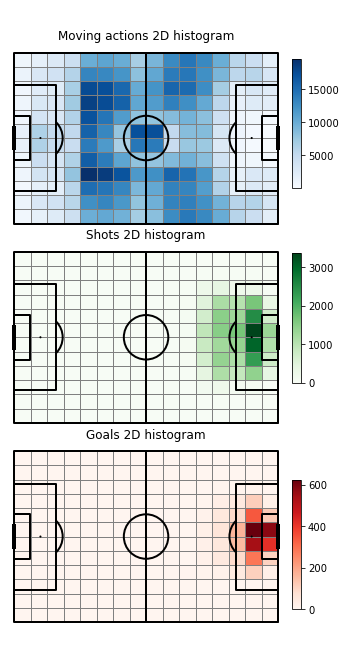

In [49]:
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, nrows=3,
                     endnote_height=0.04, title_space=0, endnote_space=0)

pcm  = pitch.heatmap(movement_binned, cmap='Blues', edgecolor='grey', ax=ax['pitch'][0])
ax_cbar = fig.add_axes((1, 0.72, 0.03, 0.2))
cbar = fig.colorbar(pcm, cax=ax_cbar)
ax['pitch'][0].set_title('Moving actions 2D histogram')


pcm  = pitch.heatmap(shots_binned, cmap='Greens', edgecolor='grey', ax=ax['pitch'][1])
ax_cbar = fig.add_axes((1, 0.42, 0.03, 0.2))
cbar = fig.colorbar(pcm, cax=ax_cbar)
ax['pitch'][1].set_title('Shots 2D histogram')

pcm  = pitch.heatmap(goals_binned, cmap='Reds', edgecolor='grey', ax=ax['pitch'][2])
ax_cbar = fig.add_axes((1, 0.07, 0.03, 0.2))
cbar = fig.colorbar(pcm, cax=ax_cbar)
ax['pitch'][2].set_title('Goals 2D histogram');


In [50]:
move_probability = move_count/(move_count+shot_count)

In [51]:
df_transfermarkt = pd.read_csv('..\data\johnspacemuller\Transfermarkt Values 2010-2021 - tm_player_values_2010_to_2021.csv', index_col=0)

# we don't care about a record each season, just want their transfermarkt url
df_transfermarkt = df_transfermarkt.drop_duplicates(subset=['player_url'])

df_transfermarkt['last_name'] = df_transfermarkt['player_name'].str.split(' ').str[-1]
df_transfermarkt['first_name'] = df_transfermarkt['player_name'].str.split(' ').str[0]
df_transfermarkt['last_name_no_accent'] = clean(df_transfermarkt['last_name'], strip_accents='unicode')
df_transfermarkt['first_initials'] = clean(df_transfermarkt['player_name'], strip_accents='unicode').str[:2]
df_transfermarkt['last_initials'] = clean(df_transfermarkt['last_name'], strip_accents='unicode').str[:2]

df_transfermarkt['player_dob'] = pd.to_datetime(df_transfermarkt['player_dob'])

df_transfermarkt['player_id'] = df_transfermarkt['player_url'].apply(lambda x: int(x[x.rindex('/') + 1:]));

recordlinkage\preprocessing\cleaning.py:114: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r'(\[.*?\]|\(.*?\)|\{.*?\})', '')
recordlinkage\preprocessing\cleaning.py:118: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(replace_by_none, '')
recordlinkage\preprocessing\cleaning.py:121: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(replace_by_whitespace, ' ')
recordlinkage\preprocessing\cleaning.py:124: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r'\s\s+', ' ')
recordlinkage\preprocessing\cleaning.py:114: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r'(\[.*?\]|\(.*?\)|\{.*?\})', '')
recordlinkage\preprocessing\cleaning.py:118: FutureWarning: The default v

In [52]:
df_top_mids_italy = df_mids_italy.head(20)

df_top_mids_italy = df_top_mids_italy.set_index('wyId')

In [53]:
df_transfermarkt = df_transfermarkt.set_index('player_id')

In [54]:
df_top_mids_italy['birthDate'] = pd.to_datetime(df_top_mids_italy['birthDate'])

In [55]:
indexer = recordlinkage.Index()

indexer.block(left_on = ['last_initials', 'first_initials', 'birthDate'], 
              right_on = ['last_initials', 'first_initials', 'player_dob']
             )

<Index>

In [56]:
candidates = indexer.index(df_top_mids_italy, df_transfermarkt)

print(str(len(df_top_mids_italy)) + ' players in Wyscout\n' + str(len(candidates)) + ' possible matches')

20 players in Wyscout
17 possible matches


In [57]:
compare = recordlinkage.Compare()

compare.string('lastName',
               'last_name',
               method='levenshtein',
               threshold=0.60,
               label='last_name'
              )

compare.string('firstName',
               'first_name',
               method='levenshtein',
               threshold=0.60,
               label='first_name'
              )

features = compare.compute(candidates, df_top_mids_italy, df_transfermarkt)

In [58]:
features['total'] = features['last_name'] + features['first_name']
features[features['total']<2]

,,last_name,first_name,total
wyId,player_id,,,
90268,215616,0.0,0.0,0.0
220359,167796,1.0,0.0,1.0


In [59]:
wyscout_transfermarkt_id_map = dict(features.index)

In [60]:
df_top_mids_italy['transfermarkt_id'] = df_top_mids_italy.index.map(wyscout_transfermarkt_id_map, na_action='ignore')

In [61]:
df_top_mids_italy['transfermarkt_id'] = df_top_mids_italy['transfermarkt_id'].fillna(-999)
df_top_mids_italy['transfermarkt_id'] = df_top_mids_italy['transfermarkt_id'].astype(int)

In [62]:
from transfermarkt_helper import get_latest_market_value

In [63]:
df_top_mids_italy['market_value_summer_2018'] = df_top_mids_italy['transfermarkt_id'].apply(lambda id: get_latest_market_value(id, wait_seconds_max=3, maximum_date=CURRENT_DATE, market_value_only=False)[0][3] if id!=-999 else None)

In [64]:
df_top_mids_italy['age'] =  (CURRENT_DATE - df_top_mids_italy['birthDate'].dt.date) / np.timedelta64(1, 'Y')
df_top_mids_italy['market_value_summer_2018_M'] = df_top_mids_italy['market_value_summer_2018'] / 1000000

In [65]:
columns_base = ['transfermarkt_id', 'firstName', 'lastName', 'team_name', 'league', 'age', 'market_value_summer_2018_M', '90s', 'overall_rank']
columns_metrics = [metric.per_90_possession_adjusted() for metric in metrics_definitions]
columns_ranks = [column + '_rank' for column in columns_metrics]

In [66]:
columns = columns_base + columns_metrics + columns_ranks

In [67]:
df_top_mids_italy[columns].sort_values('market_value_summer_2018_M', ascending=True)

,transfermarkt_id,firstName,lastName,team_name,league,age,market_value_summer_2018_M,90s,overall_rank,ground_duels_won_by_anticipation_p90_padj,interceptions_p90_padj,key_passes_p90_padj,passes_from_outside_defensive_box_p90_padj,ground_duels_won_by_anticipation_p90_padj_rank,interceptions_p90_padj_rank,key_passes_p90_padj_rank,passes_from_outside_defensive_box_p90_padj_rank
wyId,,,,,,,,,,,,,,,,,
22162,7093,Francesco,Magnanelli,Sassuolo,Italy,33.550312,1.0,28.788889,7.437037,0.498398,14.640447,0.392543,9.656551,0.696296,0.985185,0.437037,0.977778
415809,324282,Fabio,Depaoli,Chievo,Italy,21.103787,1.5,13.744444,6.859259,0.585284,10.418060,0.961245,4.806225,0.792593,0.792593,0.814815,0.644444
20850,33218,Luca,Cigarini,Cagliari,Italy,31.948637,1.8,23.555556,6.429630,0.321877,11.024300,0.359439,10.333862,0.496296,0.851852,0.400000,0.992593
20526,110928,Lorenzo,Crisetig,Bologna,Italy,25.361233,2.0,6.577778,7.044444,1.188046,11.583447,0.000000,5.294458,0.977778,0.881481,0.044444,0.711111
20943,19446,Riccardo,Montolivo,Milan,Italy,33.366873,3.0,12.611111,6.807407,0.510174,12.584301,0.297143,6.091429,0.711111,0.925926,0.311111,0.792593
246063,216179,Stefano,Sensi,Sassuolo,Italy,22.823193,4.0,12.200000,6.511111,0.573451,8.888487,1.148395,5.550574,0.777778,0.607407,0.903704,0.725926
90268,215616,Erick Antonio,Pulgar Farfán,Bologna,Italy,24.375586,4.5,32.277778,6.637037,0.464158,10.095443,0.398876,9.240621,0.659259,0.762963,0.444444,0.962963
220359,167796,Paolo Pancrazio,Faragò,Cagliari,Italy,25.298261,5.0,29.133333,6.540741,0.752198,8.587591,1.289825,5.007556,0.874074,0.540741,0.962963,0.666667
20561,61449,Senad,Lulić,Lazio,Italy,32.367537,7.0,27.722222,6.681481,0.575128,8.698816,0.796393,7.457130,0.785185,0.570370,0.762963,0.925926


In [75]:
# potential targets based on age and market value
potential_targets = df_top_mids_italy[(df_top_mids_italy['age']<30) & (df_top_mids_italy['market_value_summer_2018_M']<=15)].index
print('Found ' + str(len(potential_targets)) + ' potential transfer targets:\n' + str(potential_targets))

Found 9 potential transfer targets:
Int64Index([69400, 20526, 190167, 415809, 25405, 90268, 220359, 246063, 21290], dtype='int64', name='wyId')


In [69]:
def create_pizza(wyscout_id, 
                ax,
                parameter_names=[metric.clean_metric_name() for metric in metrics_definitions],
                value_column_names=[metric.per_90_possession_adjusted() + '_rank' for metric in metrics_definitions],
                slice_colours=[metric.pizza_slice_colour for metric in metrics_definitions],
                df=df_mids
                ):
    
    percentiles = 100 * df[df['wyId']==wyscout_id][value_column_names].to_numpy()[0]
    percentiles_int = [int(percentile) for percentile in percentiles]

    baker = PyPizza(
        params=parameter_names, 
        straight_line_color=COLOUR_ALMOST_BLACK,
        background_color=COLOUR_BACKGROUND

    )

    baker.make_pizza(
        values = percentiles_int,
        figsize=(4, 4),
        param_location=110,
        slice_colors=slice_colours,
        ax=ax
    )
                

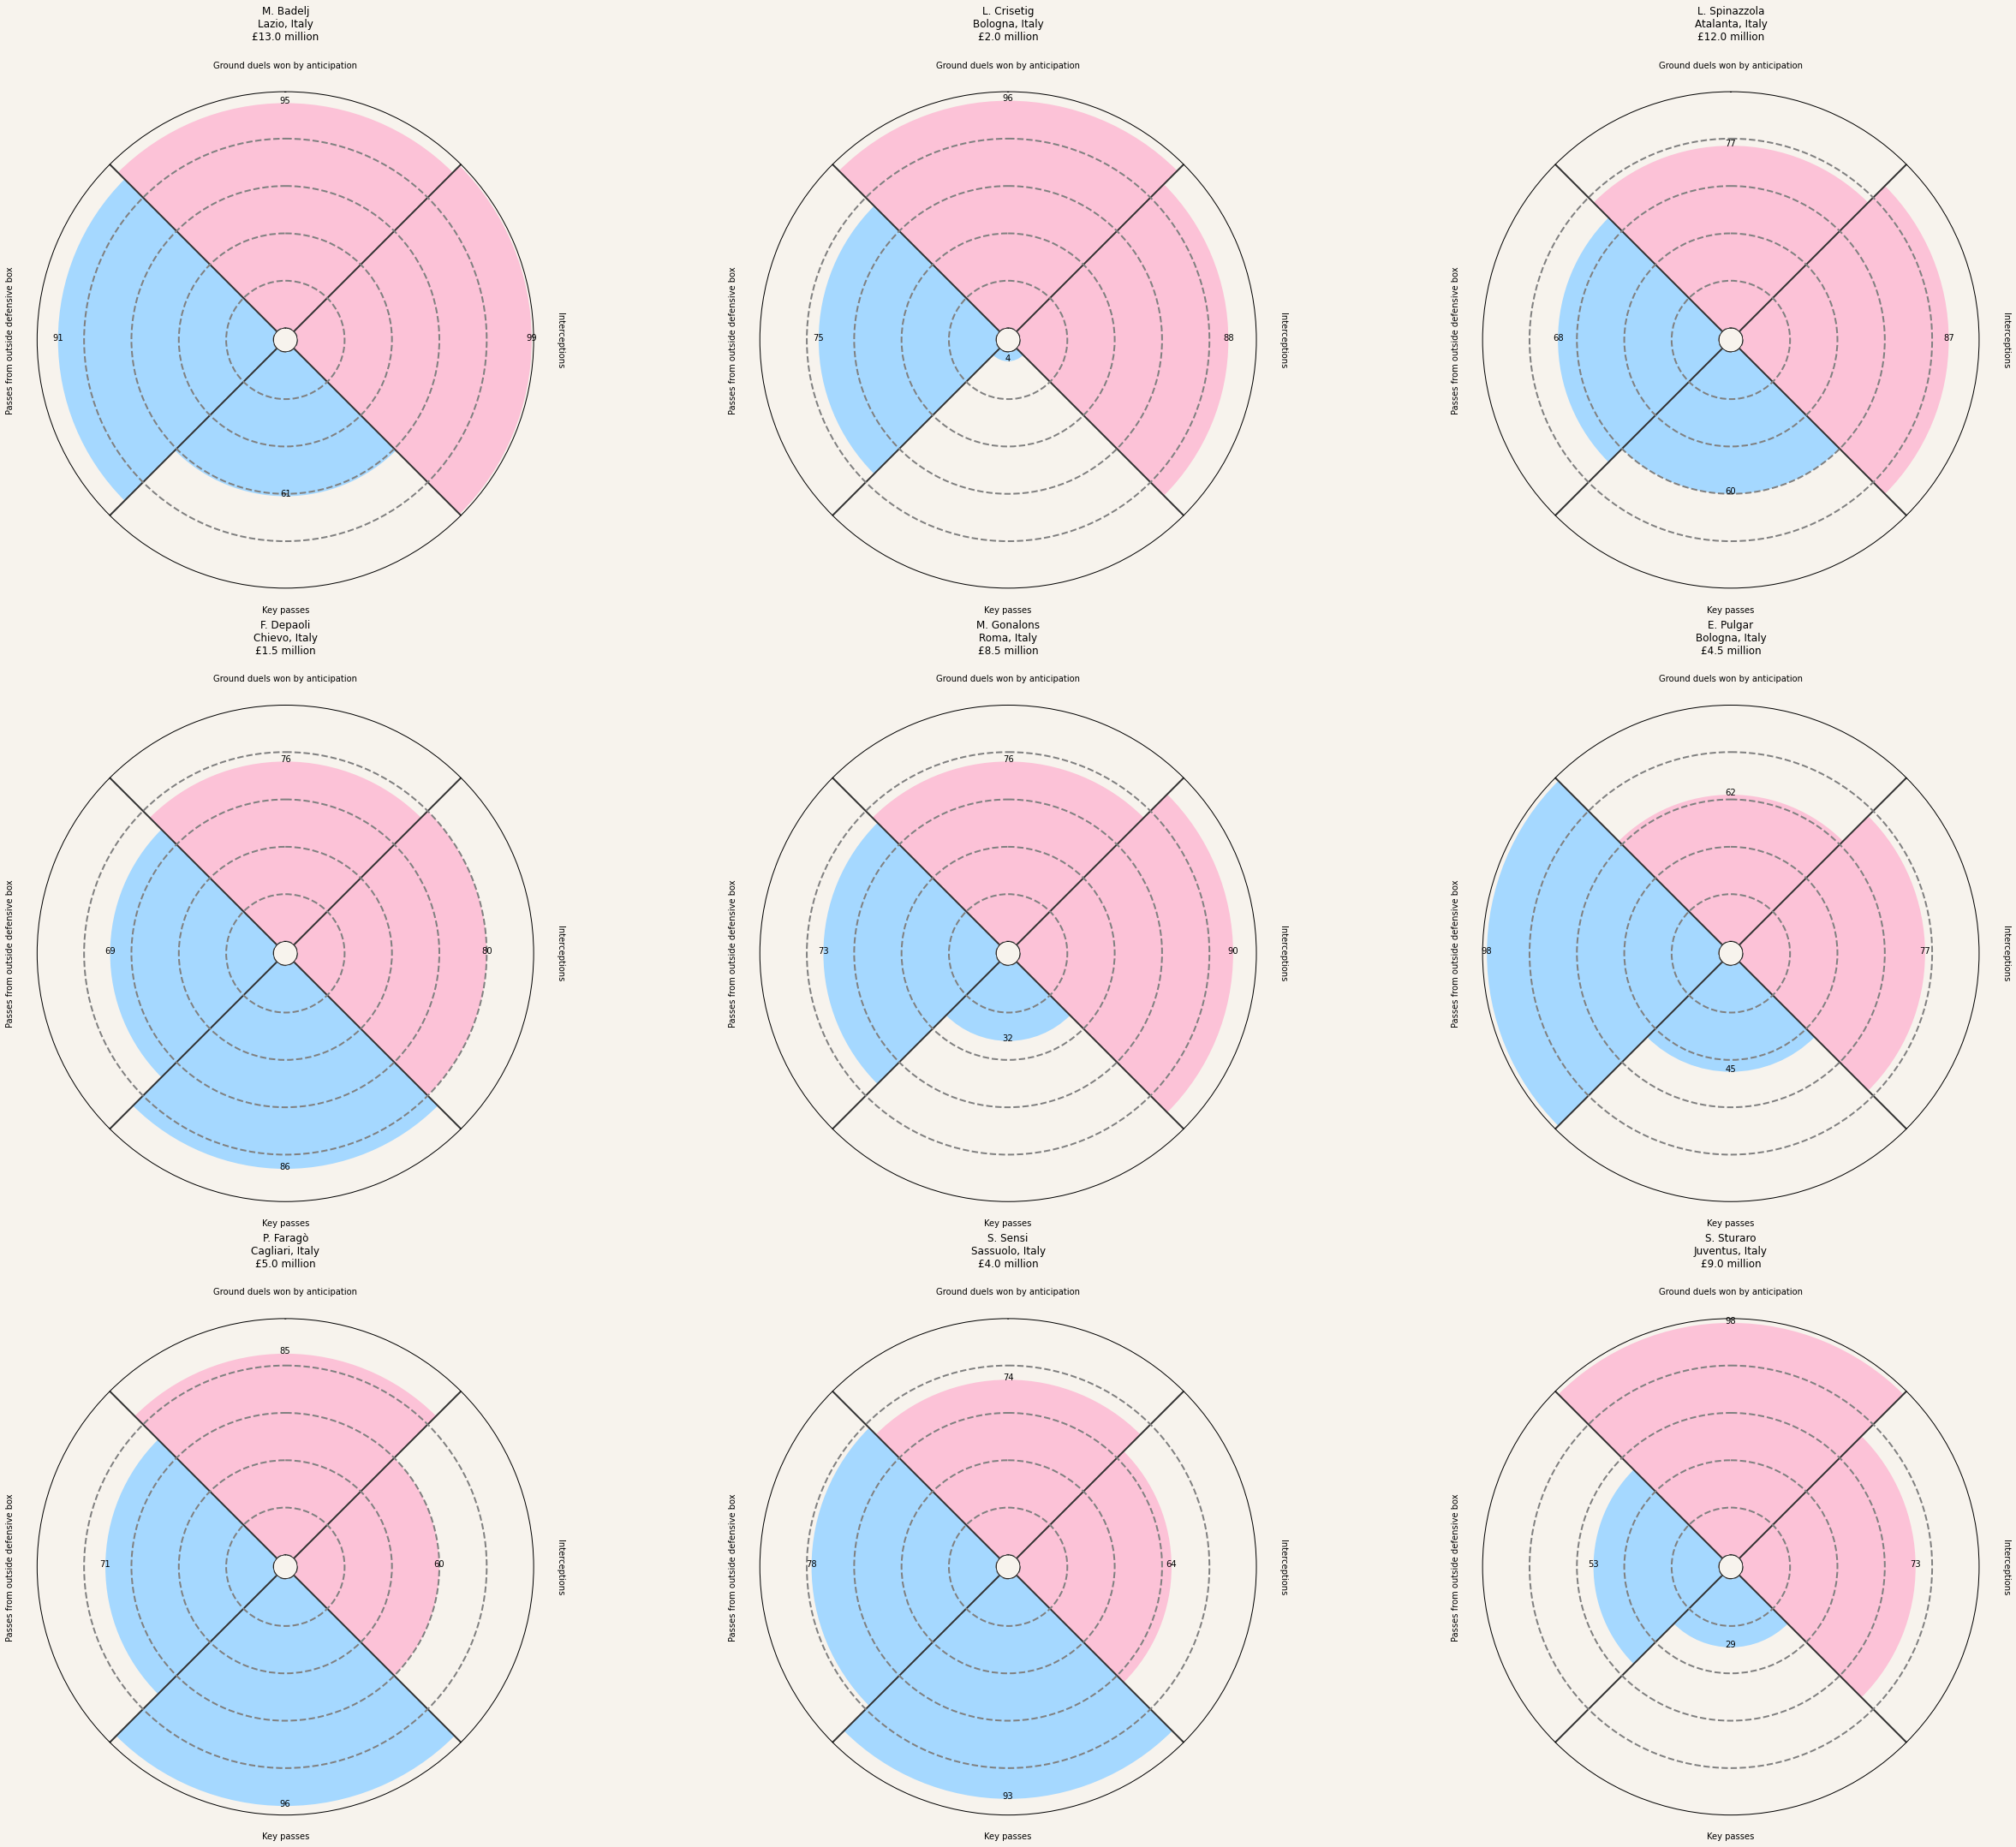

In [76]:
fig, ax = plt.subplots(nrows=3, ncols=3, subplot_kw={'projection': 'polar'}, figsize=(36,30))

fig.patch.set_color(COLOUR_BACKGROUND)
    
for i, mid_id in enumerate(potential_targets):
    player_name = df_top_mids_italy[df_top_mids_italy.index==mid_id]['shortName'].to_numpy()[0]
    team = df_top_mids_italy[df_top_mids_italy.index==mid_id]['team_name'].to_numpy()[0]
    league = df_top_mids_italy[df_top_mids_italy.index==mid_id]['league'].to_numpy()[0]
    if type(team)==float or type(league)==float:
        team_and_league = ''
    else:
        team_and_league = team + ', ' + league
    market_value = df_top_mids_italy[df_top_mids_italy.index==mid_id]['market_value_summer_2018_M'].to_numpy()[0]
    create_pizza(wyscout_id=mid_id, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(player_name + '\n' + team_and_league + '\n£' + f'{market_value:.1f}' + ' million', pad=60)
    ax.flatten()[i].patch.set_color(COLOUR_BACKGROUND)

fig.tight_layout()

In [71]:
df_brighton_mids = df_brighton_players[df_brighton_players['role_name']=='Midfielder']

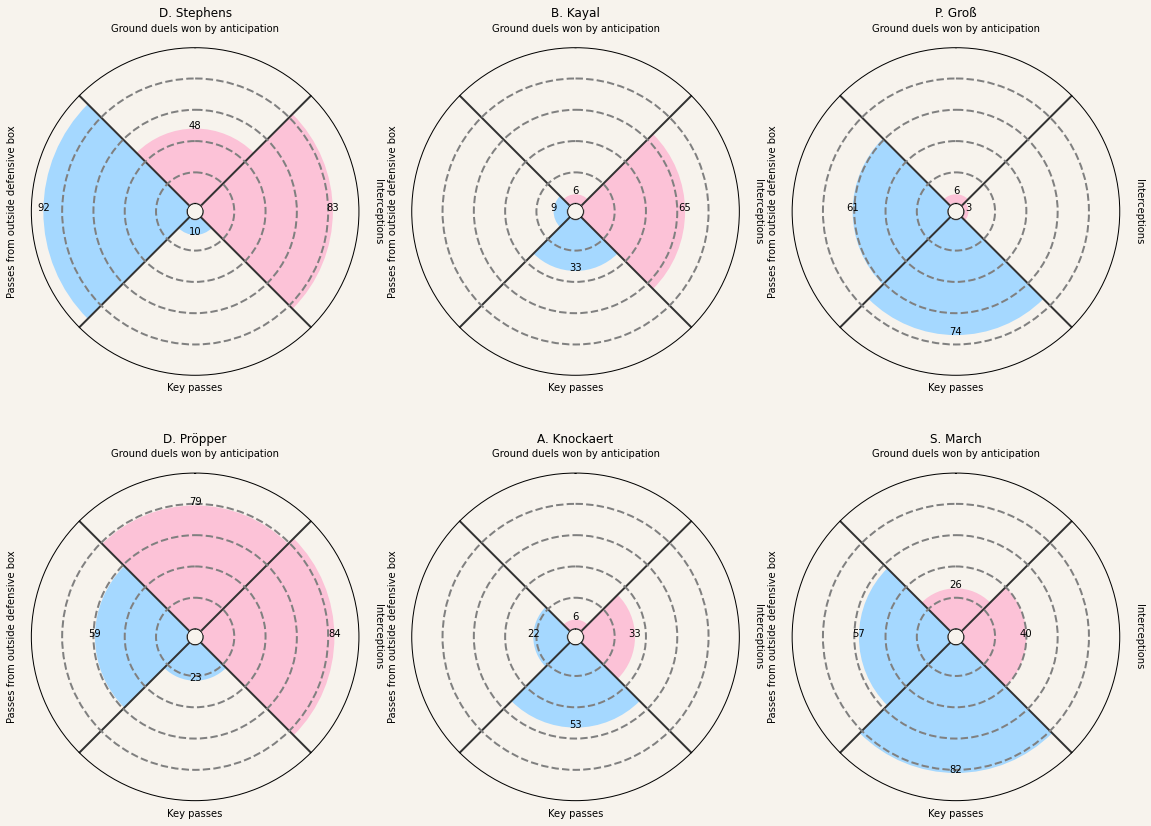

In [72]:
fig, ax = plt.subplots(nrows=2, ncols=3, subplot_kw={'projection': 'polar'}, figsize=(16,12))

fig.patch.set_color(COLOUR_BACKGROUND)
    
for i, brighton_mid_id in enumerate(df_brighton_mids['wyId']):
    player_name = df_brighton_mids[df_brighton_mids['wyId']==brighton_mid_id]['shortName'].to_numpy()[0]
    create_pizza(wyscout_id=brighton_mid_id, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(player_name, pad=30)
    ax.flatten()[i].patch.set_color(COLOUR_BACKGROUND)

fig.tight_layout()

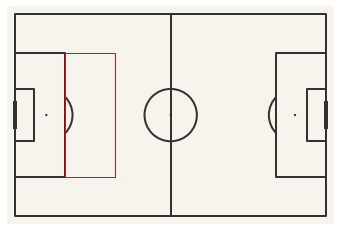

In [73]:
fig, ax = plt.subplots()
pitch = Pitch(pitch_color=COLOUR_BACKGROUND, line_color=COLOUR_ALMOST_BLACK,
              line_zorder=1, pitch_type='wyscout')
pitch.draw(ax=ax)
rect = mpl.patches.Rectangle((WYSCOUT_EDGE_OF_BOX_X, WYSCOUT_EDGE_OF_BOX_Y_MIN), WYSCOUT_EDGE_OF_BOX_X, WYSCOUT_EDGE_OF_BOX_Y_MAX - WYSCOUT_EDGE_OF_BOX_Y_MIN, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
